### Imports

In [1]:
import os
import sys
import pandas as pd
from pathlib import Path

# Find directory that contains "src" (works from project/, code/, or subdirs)
_root = Path.cwd().resolve()
while _root != _root.parent and not (_root / "src").is_dir() and not (_root / "code" / "src").is_dir():
    _root = _root.parent
_code_dir = _root if (_root / "src").is_dir() else _root / "code"
if _code_dir.exists():
    sys.path.insert(0, str(_code_dir))

# import modules
from src.models import init_models, train_models, tune_params, save_models, save_results, DATA_DIR, FILE_NAME, OUTPUT_DIR
from src.plot import visualize_results

import warnings

warnings.filterwarnings(
    "ignore",
    message="`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel`",
    category=UserWarning,
    module="sklearn.utils.parallel",
)

**Grid search**: Wider parameter ranges to explore the new dataset. For very large spaces you can use `search_type='random'` with `n_iter` in `tune_params()`.

### Config

In [2]:
LOAD = False
TUNE = True
# LOAD = True
# TUNE = False

# When LOAD is True, models are loaded from here (no_fe run). Main run uses default OUTPUT_DIR / "models".
OUT_NO_FE = OUTPUT_DIR / "no_fe"

### Load Data and Init models

In [3]:
df_model = pd.read_csv(DATA_DIR / FILE_NAME)

# limit to seasons 2010-2020
# df_model = df_model[df_model['SEASON'] >= 2010]
df_model = df_model[df_model['SEASON'] <= 2022]

### Minimal features (no FE — confronto naive)

Usiamo **solo L5** (ultime 5 partite) per la squadra di casa, **nessun** L10, streak, B2B, rest né differenziali/opponent. Così `train_models` e `tune_params` useranno solo queste colonne (inferite da `df_model`).

In [4]:
from src.models import INFO_COLS, TARGET

# Solo L5 home: niente L10, streak, B2B, rest, _OPP, _DIFF
# IS_HOME rimosso: è sempre 1 nel matchup (ogni riga = squadra di casa)
FEATURES_NAIVE = [
    'PTS_L5', 'FG_PCT_L5', 'FT_PCT_L5', 'FG3_PCT_L5',
    'AST_L5', 'REB_L5', 'WL_L5',
]
cols_keep = [c for c in df_model.columns if c in FEATURES_NAIVE or c in INFO_COLS or c == TARGET]
df_model = df_model[cols_keep].copy()
print(f"Feature minimali: {len(FEATURES_NAIVE)} -> {FEATURES_NAIVE}")
print(f"df_model: {df_model.shape[0]} righe, {df_model.shape[1]} colonne")

Feature minimali: 7 -> ['PTS_L5', 'FG_PCT_L5', 'FT_PCT_L5', 'FG3_PCT_L5', 'AST_L5', 'REB_L5', 'WL_L5']
df_model: 25502 righe, 13 colonne


### Tune / Train models

In [ ]:
# Calculate scale_pos_weight from data
n_pos = (df_model['WL'] == 1).sum()
n_neg = (df_model['WL'] == 0).sum()
scale_pos_weight_val = round(n_neg / n_pos, 2)
print(f"Class balance: {n_pos} positive, {n_neg} negative -> scale_pos_weight = {scale_pos_weight_val}")

params_grid = {
    'Dummy Baseline': {
        'strategy': ['most_frequent']
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1.0, 10.0],
        'max_iter': [500, 1000, 2000],
        'random_state': [42],
        'solver': ['lbfgs'],
        'class_weight': ['balanced']
    },
    'Decision Tree': {
        'max_depth': [5, 8, 10, 12, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [5, 10, 15, 20],
        'max_features': ['sqrt'],
        'random_state': [42],
        'class_weight': ['balanced']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [30, 50, 70, 90, 110],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto'],
        'metric': ['minkowski'],
        'n_jobs': [-1]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [5, 8, 10, 12],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt'],
        'random_state': [42],
        'n_jobs': [-1],
        'class_weight': ['balanced']
    }
}

Class balance: 15057 positive, 10445 negative -> scale_pos_weight = 0.69


In [6]:
if not LOAD and TUNE:
    print("Tuning models")
    best_params = tune_params(params_grid, df_model, random_state=42)
    
    print("-"*100)
    for model_name, params in best_params.items():
        print(model_name)
        for param, value in params.items():
            print(f"\t{param}: {value}")
        print("-"*100)
    
    # best_params is dict of dict: { model_name: best_params }. Use to update init_models defaults or set_params on models.
    models = init_models(params = best_params, load = LOAD)
else:
    if LOAD:
        print("Loading models from", OUT_NO_FE / "models")
    models = init_models(load=LOAD, load_from_dir=OUT_NO_FE / "models" if LOAD else None)
    
    print("-"*100)
    for model in models:
        print(model)
        for param, value in models[model].get_params().items():
            print(f"\t{param}: {value}")
        print("-"*100)
    
print("Training models")
results = train_models(models, df_model, load = LOAD)

Tuning models

>>> Tuning 'Dummy Baseline' (1 configs, search_type=grid)


Dummy Baseline: 100%|██████████| 1/1 [00:00<00:00, 52.16config/s]


    best log_loss: 15.32422 -> {'strategy': 'most_frequent'}

>>> Tuning 'Logistic Regression' (12 configs, search_type=grid)


Logistic Regression: 100%|██████████| 12/12 [00:00<00:00, 12.65config/s]


    best log_loss: 0.67711 -> {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 500, 'random_state': 42, 'solver': 'lbfgs'}

>>> Tuning 'Decision Tree' (60 configs, search_type=grid)


Decision Tree: 100%|██████████| 60/60 [00:11<00:00,  5.41config/s]


    best log_loss: 0.68627 -> {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'random_state': 42}

>>> Tuning 'K-Nearest Neighbors' (10 configs, search_type=grid)


K-Nearest Neighbors: 100%|██████████| 10/10 [00:05<00:00,  1.74config/s]


    best log_loss: 0.67756 -> {'algorithm': 'auto', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 110, 'weights': 'uniform'}

>>> Tuning 'Random Forest' (108 configs, search_type=grid)


Random Forest: 100%|██████████| 108/108 [04:37<00:00,  2.57s/config]


    best log_loss: 0.67537 -> {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 150, 'n_jobs': -1, 'random_state': 42}
----------------------------------------------------------------------------------------------------
Dummy Baseline
	strategy: most_frequent
----------------------------------------------------------------------------------------------------
Logistic Regression
	C: 0.01
	class_weight: balanced
	max_iter: 500
	random_state: 42
	solver: lbfgs
----------------------------------------------------------------------------------------------------
Decision Tree
	class_weight: balanced
	max_depth: 5
	max_features: sqrt
	min_samples_leaf: 20
	min_samples_split: 2
	random_state: 42
----------------------------------------------------------------------------------------------------
K-Nearest Neighbors
	algorithm: auto
	metric: minkowski
	n_jobs: -1
	n_neighbors: 110
	weights: uniform
---------------

Seasons: 100%|██████████| 18/18 [00:14<00:00,  1.26season/s]


### Save and visialize results

Modelli salvati in /home/spina/Desktop/units/ML/project/output/no_fe/models
Risultati salvati in /home/spina/Desktop/units/ML/project/output/no_fe/results.csv

>>> Average Metrics by Model:
                     Accuracy      F1     AUC     FPR     FNR  Time_s
Model                                                                
Decision Tree          0.5642  0.5575  0.5850  0.4369  0.4323  0.0189
Dummy Baseline         0.5884  0.3703  0.5000  1.0000  0.0000  0.0014
K-Nearest Neighbors    0.5957  0.4731  0.5826  0.8602  0.0859  0.2247
Logistic Regression    0.5743  0.5677  0.5975  0.4490  0.4087  0.0121
Random Forest          0.5764  0.5681  0.5953  0.4620  0.3950  0.4749


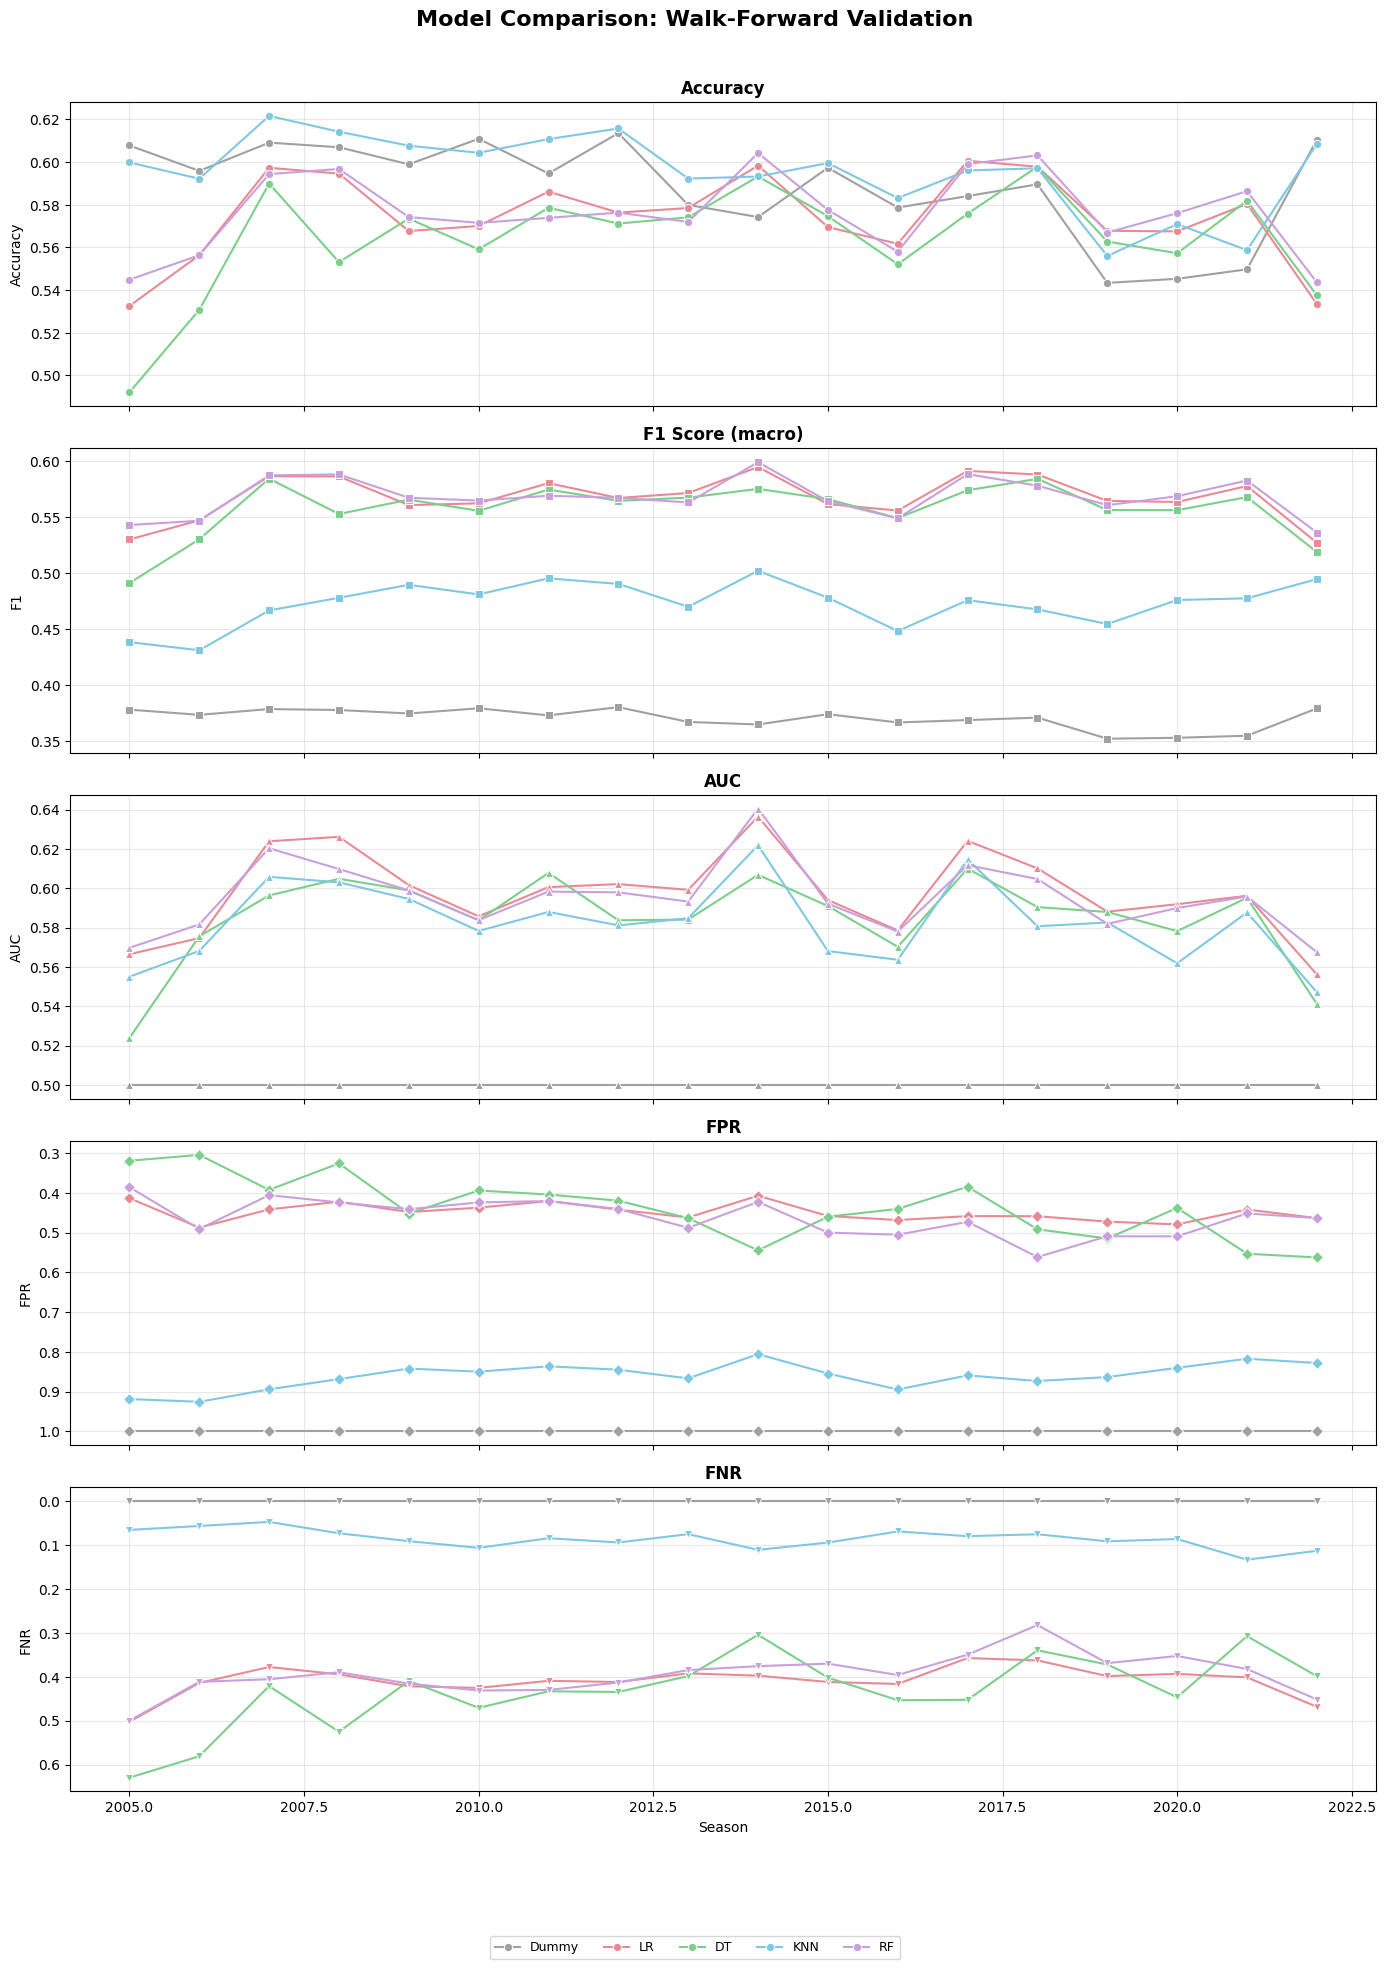

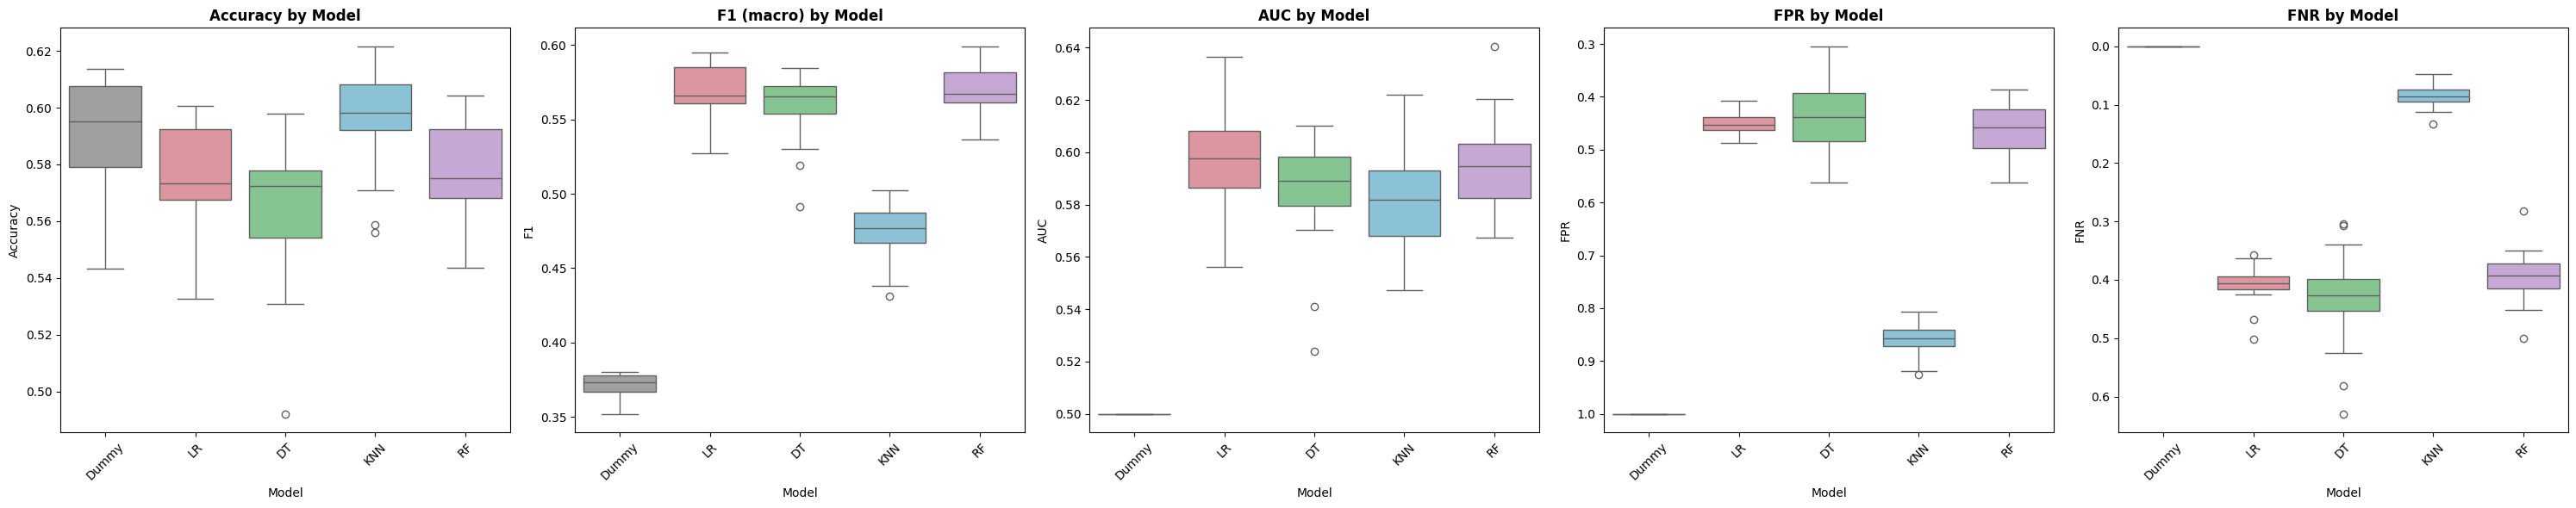


>>> Summary Statistics by Model:
                    Accuracy                              F1                  \
                        mean     std     min     max    mean     std     min   
Model                                                                          
Decision Tree         0.5642  0.0255  0.4920  0.5979  0.5575  0.0236  0.4911   
Dummy Baseline        0.5884  0.0228  0.5434  0.6136  0.3703  0.0092  0.3521   
K-Nearest Neighbors   0.5957  0.0185  0.5560  0.6217  0.4731  0.0196  0.4311   
Logistic Regression   0.5743  0.0203  0.5326  0.6006  0.5677  0.0195  0.5271   
Random Forest         0.5764  0.0185  0.5436  0.6042  0.5681  0.0172  0.5363   

                                AUC                             FPR          \
                        max    mean     std     min     max    mean     std   
Model                                                                         
Decision Tree        0.5845  0.5850  0.0224  0.5239  0.6100  0.4369  0.0779   
Dummy Bas

In [7]:
# Output in subfolder per confronto con main (full FE)
OUT_NO_FE = OUTPUT_DIR / "no_fe"
(OUT_NO_FE / "models").mkdir(parents=True, exist_ok=True)
if not LOAD:
    import pickle
    for name, model in models.items():
        with open(OUT_NO_FE / "models" / f"{name}.pkl", "wb") as f:
            pickle.dump(model, f)
    print(f"Modelli salvati in {OUT_NO_FE / 'models'}")
    pd.DataFrame(results).to_csv(OUT_NO_FE / "results.csv", index=False)
    print(f"Risultati salvati in {OUT_NO_FE / 'results.csv'}")
visualize_results(results, OUT_NO_FE)  # plot in output/no_fe/model_comparison.png